<a href="https://colab.research.google.com/github/kwanderer/MachineLearning/blob/main/MD_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



#Datu kopa

Datu kopas avots: https://www.kaggle.com/uysalserkan/fault-induction-motor-dataset

Darbā tiek izmantota indukcijas motora parametru datu bāze. Izmantotajā datu kopā ir dati, kas tika iegūti SpectraQuest aparatūras kļūdu simulatorā (Machinery Fault Simulator).

Katra mērījumu secība tika ģenerēta ar frekvenci 50 kHz 5 sekunžu laikā, kopā 250 000 mērījumi.

Dati ir apkopoti vairākos failos, dažādos darbības stāvokļos un to apjoms ir ļoti liels. Šajā darbā tika izmantota daļa(viena mērījumu secība) no motora normālas darbības datiem.


Dati ir apkopoti tabulā, kura satur 8 parametrus. Dati ir iedalīti sekojošās kolonas:

**tachometer** – tahometra signāls, kas ļauj novērtēt rotācijas frekvenci

**und-accelerometer-axial** - apakšā esošā gultņa akselerometrs (aksiālais virziens)

**und-accelerometer-radial** – apakšā esošā gultņa akselerometrs (radiālais virziens)

**und-accelerometer-tangential** - apakšā esošā gultņa akselerometrs (tangenciālais virziens)

**over-accelerometer-axial** - pārkares gultņa akselerometrs (aksiālais virziens)

**over-accelerometer-radial** – pārkares gultņa akselerometrs (radiālais  virziens)

**over-accelerometer-tangential**  - pārkares gultņa akselerometrs (tangenciālais virziens)

**microphone** – mikrofona vērtība


#Datu ielasīšana un satura vizualizācija

In [1]:
import keras
from keras.layers import LSTM, Dropout, Dense
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn import linear_model  #pip install sklearn - loti plasa masinapmacibas biblioteka
from sklearn.linear_model import LinearRegression  
import csv          #pip install csv - darbam ar CSV datu kopam
import requests     #pip install requests  - vienkarsakam darbam ar tiessaistes CSV datu kopam tiessaistes

import matplotlib
import matplotlib.pyplot as plt

import glob


In [2]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/MyDrive/Colab Notebooks/data/motor/")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#extension = 'csv'
#all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [4]:
#combine all files in the list
#combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
#combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

In [5]:
data = pd.read_csv("combined_csv.csv")

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 9 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   tachometer                     250000 non-null  float64
 1   und-accelerometer-axial        250000 non-null  float64
 2   und-accelerometer-radial       250000 non-null  float64
 3   und-accelerometer-tangential   250000 non-null  float64
 4   over-accelerometer-axial       250000 non-null  float64
 5   over-accelerometer-radial      250000 non-null  float64
 6   over-accelerometer-tangential  250000 non-null  float64
 7   microphone                     250000 non-null  float64
 8   Class                          250000 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 17.2 MB


In [7]:
rec_count = len(data)
rec_count

250000

In [8]:
sequence_length = 200

In [9]:
def generate_data(X, y, sequence_length = 200, step = 1):
    X_local = []
    y_local = []
    for start in range(0, len(data) - sequence_length, step):
        end = start + sequence_length
        X_local.append(X[start:end])
        y_local.append(y[end-1])
    return np.array(X_local), np.array(y_local)

X_sequence, y = generate_data(data.loc[:, "tachometer":"microphone"].values, data.Class)

In [10]:
X_sequence.shape, y.shape

((249800, 200, 8), (249800,))

In [11]:
model = keras.Sequential()
model.add(LSTM(100, input_shape = (200, 8)))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy"
              , metrics=[keras.metrics.binary_accuracy]
              , optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               43600     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 43,701
Trainable params: 43,701
Non-trainable params: 0
_________________________________________________________________


In [12]:
training_size = int(len(X_sequence) * 0.7)

In [13]:
X_train, y_train = X_sequence[:training_size], y[:training_size]
X_test, y_test = X_sequence[training_size:], y[training_size:]

In [14]:
model.fit(X_train, y_train, batch_size=64, epochs=30)

Epoch 1/30
2733/2733 [==============================] - 627s 228ms/step - loss: 0.0029 - binary_accuracy: 0.9995
Epoch 2/30
2733/2733 [==============================] - 706s 259ms/step - loss: 2.0100e-06 - binary_accuracy: 1.0000
Epoch 3/30
2733/2733 [==============================] - 682s 250ms/step - loss: 4.9150e-07 - binary_accuracy: 1.0000
Epoch 4/30
2733/2733 [==============================] - 581s 213ms/step - loss: 1.3361e-07 - binary_accuracy: 1.0000
Epoch 5/30
2733/2733 [==============================] - 479s 175ms/step - loss: 3.6679e-08 - binary_accuracy: 1.0000
Epoch 6/30
2733/2733 [==============================] - 478s 175ms/step - loss: 9.8339e-09 - binary_accuracy: 1.0000
Epoch 7/30
2733/2733 [==============================] - 467s 171ms/step - loss: 3.0285e-09 - binary_accuracy: 1.0000
Epoch 8/30
2733/2733 [==============================] - 476s 174ms/step - loss: 1.1242e-09 - binary_accuracy: 1.0000
Epoch 9/30
2733/2733 [==============================] - 486s 178ms/s

In [15]:
model.evaluate(X_test, y_test)

2342/2342 [==============================] - 94s 40ms/step - loss: 3.6280e-13 - binary_accuracy: 1.0000


[3.628017211741025e-13, 1.0]

In [ ]:
y_test_prob = model.predict(X_test, verbose=1)

In [17]:
y_test_pred = np.where(y_test_prob > 0.5, 1, 0)

In [ ]:
from sklearn.metrics import confusion_matrix

In [19]:
confusion_matrix(y_test, y_test_pred)

array([[74940]])

Confusion matrix, without normalization
[[74940]]
Normalized confusion matrix
[[1.]]


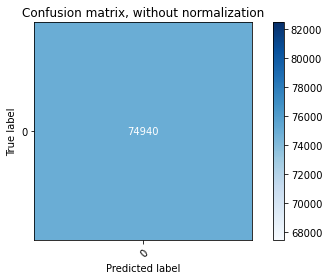

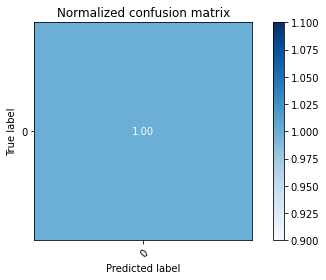

In [20]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

class_names = np.array(['0', '1'])

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, len(np.unique(y))-0.5)
    plt.ylim(len(np.unique(y))-0.5, -0.5)
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_test_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_test_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()